In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import ast
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [186]:
%%time

data = pd.read_csv('train_main.csv')

CPU times: total: 12.2 s
Wall time: 12.6 s


In [187]:
data.head()

,id_index,accept_handicapped,archived,response_letter_required,hidden,premium,allow_messages,name,employment_id,employer_name,...,specialization_id,specialization_profarea_name,specialization_profarea_id,specialization_name,line_name,station_id,line_id,lat,station_name,lng
0,495,False,False,False,False,False,True,Специалист по продажам и обслуживанию (Таганская),full,Билайн,...,"{17.269,17.183}",{Продажи},{17},"{""Начальный уровень, Мало опыта"",""Телекоммуник...",NaN,NaN,NaN,NaN,NaN,NaN
1,1,False,False,False,False,False,True,Заместитель начальника службы текущего и капит...,full,Нефтяная Акционерная Компания АКИ-ОТЫР,...,"{10.191,10.80,2.44}","{""Бухгалтерия, управленческий учет, финансы пр...","{2,10}","{Инженер,""Бюджетирование и планирование"",Нефть}",NaN,NaN,NaN,NaN,NaN,NaN
2,2,False,False,False,False,False,True,Инженер по технадзору,full,СтеллаСтрой,...,{20.83},"{""Строительство, недвижимость""}",{20},{Инженер},NaN,NaN,NaN,NaN,NaN,NaN
3,3,False,False,False,False,False,True,Системный администратор,full,Казанский жировой комбинат,...,{1.273},"{""Информационные технологии, интернет, телеком""}",{1},"{""Системный администратор""}",NaN,NaN,NaN,NaN,NaN,NaN
4,15,False,False,False,False,False,True,Менеджер по продажам,full,РенКапСтрой,...,"{17.242,20.189,20.375,20.70}","{Продажи,""Строительство, недвижимость""}","{20,17}","{""Прямые продажи"",Девелопер,""Нежилые помещения...",NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696698 entries, 0 to 696697
Data columns (total 43 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id_index                      696698 non-null  int64  
 1   accept_handicapped            696698 non-null  bool   
 2   archived                      696698 non-null  bool   
 3   response_letter_required      696698 non-null  bool   
 4   hidden                        696698 non-null  bool   
 5   premium                       696698 non-null  bool   
 6   allow_messages                696698 non-null  bool   
 7   name                          696698 non-null  object 
 8   employment_id                 696698 non-null  object 
 9   employer_name                 696696 non-null  object 
 10  employer_id                   695718 non-null  float64
 11  billing_type_id               696698 non-null  object 
 12  type_id                       696698 non-nul

In [189]:
#Не содержатся ли в данных какие-то символы, которые могли остаться при парсинге

def find_substring(values):
    values = str(values)
    #extensionsToCheck = ["[", "]", "{", "}",'<','>','/']
    extensionsToCheck = ["[", "]", "{", "}","(",")"]
    if any(ext in values for ext in extensionsToCheck):
        return True
    else:
        return False

bad_col = []    
    
for column in data.columns:
    cnt = data[column].apply(find_substring).sum()
    if cnt>0:
        bad_col.append(column)
        print("{}, плохих значений {}".format(column,cnt))

name, плохих значений 109263
employer_name, плохих значений 12204
area_name, плохих значений 15164
address_city, плохих значений 100
address_street, плохих значений 369
address_metro_station_name, плохих значений 89
department_name, плохих значений 373
key_skills_list, плохих значений 30712
specialization_id, плохих значений 696698
specialization_profarea_name, плохих значений 696698
specialization_profarea_id, плохих значений 696698
specialization_name, плохих значений 696698
station_name, плохих значений 89


In [190]:
extensionsToCheck = ["[", "]", "{", "}","_",'<','>','/',"(",")"]
for col in bad_col:
    cnt = 0
    print(col+':')
    for i in data[col]:
        try:
            if any(ext in i for ext in extensionsToCheck):
                cnt +=1
                print(i)
            if cnt>5:
                print('---------------------------------------------')
                break
        except:
            continue

name:
Специалист по продажам и обслуживанию (Таганская)
Продавец - консультант (г. Балашиха)
Старший менеджер по товару (старший кладовщик) ТЦ "ГОРОДОК"
Продавец в салон связи (м. Новогиреево)
Продавец-консультант (м. Печатники)
Промоутер консультант/ продавец консультант бытовой техники
---------------------------------------------
employer_name:
Мобильные ТелеСистемы (МТС)
Мобильные ТелеСистемы (МТС)
FINN FLARE (Алтын Самрук, ТОО)
Мобильные ТелеСистемы (МТС)
Мобильные ТелеСистемы (МТС)
Мобильные ТелеСистемы (МТС)
---------------------------------------------
area_name:
Иваново (Ивановская область)
Иваново (Ивановская область)
Фокино (Приморский край)
Аксай (Ростовская область)
Благовещенск (Амурская область)
Арысь (ЮКО)
---------------------------------------------
address_city:
д. Рубежевичи (Столбцовский р-н)
д. Рубежевичи (Столбцовский р-н)
д. Рубежевичи (Столбцовский р-н)
д. Рубежевичи (Столбцовский р-н)
д. Рубежевичи (Столбцовский р-н)
Дзержинск (Нижегородская область)
---------

In [191]:
text_columns = [
    'address_city',
    'address_street',
    'area_name',
    'line_name',
    'station_name',
    'address_metro_line_name',
    'address_metro_station_name'
]

lists_columns = [
    'specialization_id',
    'specialization_profarea_name',
    'specialization_profarea_id',
    'specialization_name'
]

categorial_columns = [
    'employment_id', #['full' 'part' 'project' 'probation']
    'billing_type_id',#['free' 'standard_plus' 'standard' 'premium']
    'type_id',#['open' 'anonymous']
    'schedule_id',#['fullDay' 'flexible' 'shift' 'remote' 'flyInFlyOut']
    'salary_currency',#['RUR' 'BYR' 'UAH' 'KZT' 'USD' 'AZN' 'UZS' 'EUR' 'KGS']
    'experience_id',#['between3And6' 'between1And3' 'noExperience' 'moreThan6']
]

In [192]:
###Попробуем заменить пропущенные значения в целевых переменных на основе среднего значения по столбцам - отрасли, опыта работы и графика

In [193]:
print(data[data['salary_from'].isna()].shape[0]/data.shape[0]*100)
print(data[data['salary_to'].isna()].shape[0]/data.shape[0]*100)
print(data[(data['salary_from'].isna()) & (data['salary_to'].isna())].shape[0]/data.shape[0]*100)

7.264697185868195
43.88386359656551
0.0


In [194]:
# def get_first_profarea_name(value):
#     value = value.replace('{','').replace('}','').replace('"','')
#     try:
#         values = value.split(',')
#         return values[0]
#     except:
#         return value
    
# data['first_profarea_name'] = data.specialization_profarea_name.apply(get_first_profarea_name)
# group_col = ['first_profarea_name','experience_id','schedule_id','area_name']
# data['salary_from'] =  data.groupby(group_col, sort=False)['salary_from'].apply(lambda x: x.fillna(x.mean()))
# data['salary_to'] =  data.groupby(group_col, sort=False)['salary_to'].apply(lambda x: x.fillna(x.mean()))
# data[data.salary_from>data.salary_to][['salary_from','salary_to']]

id_index - 0%
accept_handicapped - 0%
archived - 0%
response_letter_required - 0%
hidden - 0%
premium - 0%
allow_messages - 0%
name - 0%
employment_id - 0%
employer_name - 0%
employer_id - 0%
billing_type_id - 0%
type_id - 0%
schedule_id - 0%
salary_to - 44%
salary_from - 7%
salary_currency - 0%
area_id - 0%
area_name - 0%
experience_id - 0%
address_city - 70%
address_street - 72%
address_lat - 69%
address_lng - 69%
address_metro_line_name - 87%
address_metro_station_id - 87%
address_metro_line_id - 87%
address_metro_lat - 87%
address_metro_station_name - 87%
address_metro_lng - 87%
test_required - 0%
department_name - 97%
key_skills_list - 96%
specialization_id - 0%
specialization_profarea_name - 0%
specialization_profarea_id - 0%
specialization_name - 0%
line_name - 87%
station_id - 87%
line_id - 87%
lat - 87%
station_name - 87%
lng - 87%


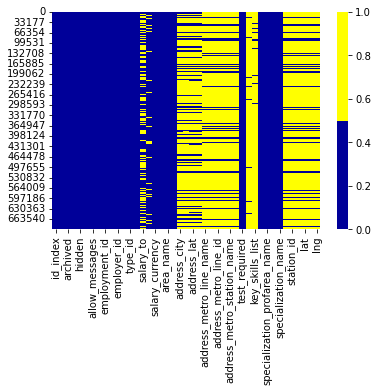

In [195]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))

for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

In [196]:
data = pd.get_dummies(data, columns=categorial_columns)

In [197]:
labelencoder = LabelEncoder()

In [198]:
data[text_columns] = data[text_columns].apply(LabelEncoder().fit_transform)

In [199]:
data = data.drop(['department_name','key_skills_list'], axis=1)

In [200]:
# all_item = np.array([])
# for item in data.specialization_id:
#     item_list = list(ast.literal_eval(item))
#     all_item = np.append(all_item, item_list)
        
# unique, counts = np.unique(all_skills, return_counts=True)
# counts.sum()

In [201]:
for i in data[text_columns].columns:
    cnt = data[i].nunique()
    print("Столбец: {}, уникальных элементов:{}".format(i,cnt))

Столбец: address_city, уникальных элементов:2091
Столбец: address_street, уникальных элементов:12272
Столбец: area_name, уникальных элементов:1692
Столбец: line_name, уникальных элементов:33
Столбец: station_name, уникальных элементов:366
Столбец: address_metro_line_name, уникальных элементов:33
Столбец: address_metro_station_name, уникальных элементов:366


In [202]:
def name_clear(value):
    try:
        value = re.sub(r'\([^)]*\)', '', value)
        value = "".join(value.rstrip())
        return value
    except:
        return np.nan
    
data.name = data.name.apply(name_clear)
print(data.name.nunique())

104295


In [203]:
def spec_name_to_string(value):
    try:
        value = str(value).replace('{', '').replace('}', '').replace('"', '')
        return value
    except:
        print(value)

for column_with_lists in lists_columns: 
    data[column_with_lists] = data[column_with_lists].apply(spec_name_to_string)

In [204]:
#https://www.kaggle.com/code/sudalairajkumar/simple-feature-engg-notebook-spooky-author/notebook

In [205]:
# for string in data.name:
#     for symb in string:
#         if not symb.isalpha() and not symb.isspace():
#             print(string)

In [206]:
data.to_csv('data_atfer_prepr.csv')

In [ ]:
data = pd.read_csv('data_atfer_prepr.csv')

In [79]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,3))

In [81]:
full_tfidf = tfidf_vec.fit_transform(specialization_name['specialization_name_string'].values.tolist())

In [82]:
sp_string_name = tfidf_vec.transform(train_df['text'].values.tolist())

<696698x2280 sparse matrix of type '<class 'numpy.float64'>'
	with 4842021 stored elements in Compressed Sparse Row format>

In [84]:
full_tfidf[0]

<1x2280 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [88]:
data.select_dtypes(include=['object']).columns.tolist()

['name',
 'employer_name',
 'area_name',
 'address_city',
 'address_street',
 'address_metro_line_name',
 'address_metro_station_name',
 'specialization_id',
 'specialization_profarea_name',
 'specialization_profarea_id',
 'specialization_name',
 'line_name',
 'station_name']

In [61]:
specialization_name

0         {"Начальный уровень, Мало опыта","Телекоммуник...
1           {Инженер,"Бюджетирование и планирование",Нефть}
2                                                 {Инженер}
3                               {"Системный администратор"}
4         {"Прямые продажи",Девелопер,"Нежилые помещения...
                                ...                        
696693                          {"Системный администратор"}
696694                         {"Руководство бухгалтерией"}
696695    {"Системный администратор","Поддержка, Helpdes...
696696    {"Торговый представитель",Дистрибуция,"Начальн...
696697                                     {Машиностроение}
Name: specialization_name, Length: 696698, dtype: object

In [104]:
data.columns

Index(['id_index', 'accept_handicapped', 'archived',
       'response_letter_required', 'hidden', 'premium', 'allow_messages',
       'name', 'employer_name', 'employer_id', 'salary_to', 'salary_from',
       'area_id', 'area_name', 'address_city', 'address_street', 'address_lat',
       'address_lng', 'address_metro_line_name', 'address_metro_station_id',
       'address_metro_line_id', 'address_metro_lat',
       'address_metro_station_name', 'address_metro_lng', 'test_required',
       'specialization_id', 'specialization_profarea_name',
       'specialization_profarea_id', 'specialization_name', 'line_name',
       'station_id', 'line_id', 'lat', 'station_name', 'lng',
       'employment_id_full', 'employment_id_part', 'employment_id_probation',
       'employment_id_project', 'employment_id_volunteer',
       'billing_type_id_free', 'billing_type_id_premium',
       'billing_type_id_standard', 'billing_type_id_standard_plus',
       'type_id_anonymous', 'type_id_direct', 'type_id_

In [87]:
data.dtypes

id_index                      int64
accept_handicapped             bool
archived                       bool
response_letter_required       bool
hidden                         bool
                              ...  
salary_currency_UZS           uint8
experience_id_between1And3    uint8
experience_id_between3And6    uint8
experience_id_moreThan6       uint8
experience_id_noExperience    uint8
Length: 66, dtype: object

In [ ]:
columns_to_ = ['address_city',
               'address_street',
               'area_name',
               'line_name',
               'station_name',
               'address_metro_line_name',
               'address_metro_station_name'
              ]

columns_to_ = [
    'specialization_id',
    'specialization_profarea_name',
    'specialization_profarea_id',
    'specialization_name',
]

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696698 entries, 0 to 696697
Data columns (total 66 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id_index                       696698 non-null  int64  
 1   accept_handicapped             696698 non-null  bool   
 2   archived                       696698 non-null  bool   
 3   response_letter_required       696698 non-null  bool   
 4   hidden                         696698 non-null  bool   
 5   premium                        696698 non-null  bool   
 6   allow_messages                 696698 non-null  bool   
 7   name                           696698 non-null  object 
 8   employer_name                  696696 non-null  object 
 9   employer_id                    695718 non-null  float64
 10  salary_to                      390960 non-null  float64
 11  salary_from                    646085 non-null  float64
 12  area_id                       

In [101]:
print(data['address_metro_station_name'].nunique())
print(data['address_metro_station_name'].unique())

365
[nan 'Печатники' 'Новокосино' 'Киевская' 'Автозаводская' 'Калужская'
 'Выборгская' 'Звенигородская' 'Алтуфьево' 'Авиамоторная' 'Пролетарская'
 'Электрозаводская' 'Уральская' 'Парк Челюскинцев' 'Спортивная' 'Москва'
 'Академия наук' 'Алмалы' 'Суконная слобода' 'Березовая роща' 'Уралмаш'
 'Могилевская' 'Райымбек батыра' 'Октябрьское поле' 'Маяковская'
 'Ладожская' 'Строгино' 'Площадь Восстания' 'Китай-город' 'Партизанская'
 'Малиновка' 'Полежаевская' 'Центральный рынок' 'Выхино' 'Лесная'
 'Аэропорт' 'Царицыно' 'Горьковская' 'Петроградская' 'Алексеевская'
 'Шоссе энтузиастов' 'Аннино' 'Южная' 'Ботанический сад' 'Старая Деревня'
 'Сокольники' 'Чкаловская' 'Речной вокзал' 'Университет' 'Юнгородок'
 'Уручье' 'Курская' 'Обводный Канал' 'Бибирево' 'Садовая' 'Чернышевская'
 'Балтийская' 'Удельная' 'Лиговский проспект' 'Мякинино'
 'Невский проспект' 'Козья слобода' 'Московская' 'Планерная'
 'Новокузнецкая' 'Рязанский проспект' 'Черкизовская' 'Купчино' 'Жулебино'
 'Тимирязевская' 'Парнас' 'Но